In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model

from keras.layers import Input, Dense, Dropout, Activation, Flatten, ReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Load MNIST dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [6]:
z_dim = 100

In [8]:
from keras.layers import Dense, LeakyReLU

In [23]:
# Optimizer
import tensorflow as tf
adam = tf.keras.optimizers.legacy.Adam(lr=0.0002, beta_1=0.5)


g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation= LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])



# Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [28]:

from tqdm.notebook import tqdm
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):

    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9

            # Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            y2 = np.ones(BATCH_SIZE)

            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)


        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
1/1 [==============================] - 0s 107ms/step


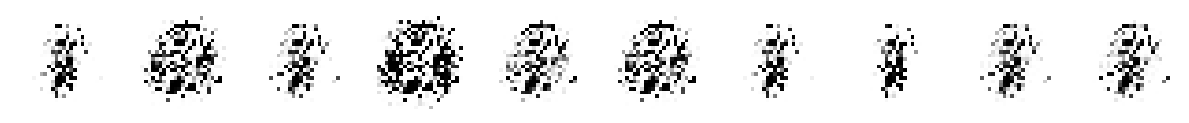

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
4/4 [==============================] - 0s 8ms/step


In [ ]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)